# Hilbert Schmidt distance between HEE circuit generated states and Maximally Mixed State

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

import warnings
warnings.filterwarnings('ignore')

In [4]:
def analytical(s,n):
    return (2**s - 2**(-s))/(2**n + 1)

# HSD : Hilbert Schmidt distance
# HEE : Hardware Efficient Embedding
# MMS : Maximally Mixed State
class HSD:
    def __init__(self, nqubits, nlayers, s, repeat_params = True):
        self.nqubits = nqubits
        self.nlayers = nlayers
        self.s = s
        self.repeat_params = repeat_params

    def HEE(self, circuit, params):
        for i in range(self.nqubits):
            circuit.rx(params[i], i)
            circuit.ry(params[i + self.nqubits], i)
        for i in range(self.nqubits - 1):
            circuit.cx(i, i+1)

    def HSD_from_MMS(self, params):
        circuit = QuantumCircuit(self.nqubits)

        if params is None:
            if self.repeat_params:
                params = np.random.uniform(0, 2*np.pi, 2*self.nqubits)
                for i in range(self.nlayers):
                    self.HEE(circuit, params)
                    circuit.barrier()
            else:
                params = np.random.uniform(0, 2*np.pi, 2*self.nqubits*self.nlayers)
                for i in range(self.nlayers):
                    self.HEE(circuit, params[2*self.nqubits*i:2*self.nqubits*(i+1)])
                    circuit.barrier()
        else:
            if self.repeat_params:
                for i in range(self.nlayers):
                    self.HEE(circuit, params)
                    circuit.barrier()
            else:
                for i in range(self.nlayers):
                    self.HEE(circuit, params[2*self.nqubits*i:2*self.nqubits*(i+1)])
                    circuit.barrier()

        rho = qi.DensityMatrix.from_instruction(circuit)
        partial_rho = qi.partial_trace(rho, list(np.arange(self.nqubits - self.s)))

        return qi.purity(partial_rho) - 1/2**self.s

## Circuit structure

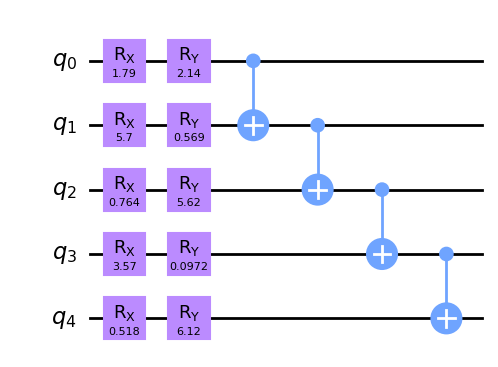

In [5]:
nqubits = 5

circuit = QuantumCircuit(nqubits)
hsd = HSD(nqubits, 1, 2)
hsd.HEE(circuit, np.random.uniform(0, 2*np.pi, 2*nqubits))
circuit.draw('mpl')

## Plot Hilbert Schmidt distance between HEE circuit generated states and Maximally Mixed State

### Gate parameters are randomly chosen

#### Not repeat parameters

In [20]:
nsamples = 10**3
nqubits_list = np.arange(2, 8)
nlayers_list = [2,10,50]
s = 1
params = None
repeat_params = False

int_hs_distance_each_nlayers = []
for nlayers in nlayers_list:
    int_hs_distance_each_nqubits = []
    for nqubits in nqubits_list:
        hsd = HSD(nqubits, nlayers, s, repeat_params)
        samples = []
        for _ in range(nsamples):
            samples.append(hsd.HSD_from_MMS(params))
        mean = np.mean(samples)
        int_hs_distance_each_nqubits.append(mean)
    int_hs_distance_each_nlayers.append(int_hs_distance_each_nqubits)

In [21]:
l = int_hs_distance_each_nlayers
path = "results/data/int_hs_distance_each_nlayers.pkl"
with open(path, "wb") as f:
    pickle.dump(l, f)

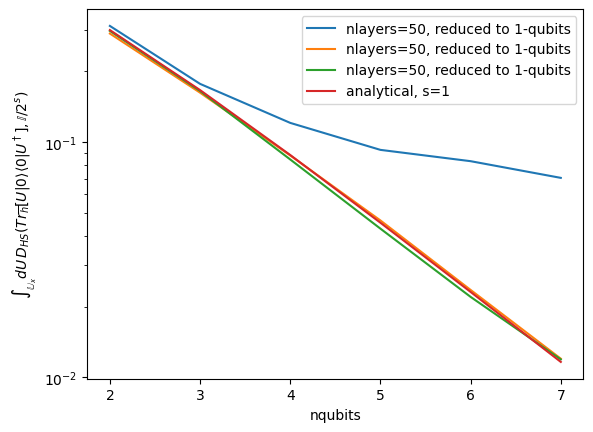

In [22]:
for i,nlayers in enumerate(nlayers_list):
    plt.semilogy(nqubits_list, int_hs_distance_each_nlayers[i], label=f'nlayers={nlayers}, reduced to {s}-qubits')

analytical_points = analytical(s, nqubits_list)
plt.semilogy(nqubits_list, analytical_points, label=f'analytical, s={s}')

plt.xlabel('nqubits')
#plt.ylabel('$D_{HS} ( \\rho_i^{(h)} , \mathbb{I}/2^s )$')
plt.ylabel('$\int_{\mathbb{U}_x}dU\,D_{HS}(Tr_{\overline{h}}[U|0\\rangle\langle0| U^\dagger],\mathbb{I}/2^s)$')
plt.legend()
plt.show()

#### Repeat parameters

In [23]:
nsamples = 10**3
nqubits_list = np.arange(2, 8)
nlayers_list = [2,10,50]
s = 1
params = None
repeat_params = True

int_hs_distance_each_nlayers_repeat = []
for nlayers in nlayers_list:
    int_hs_distance_each_nqubits = []
    for nqubits in nqubits_list:
        hsd = HSD(nqubits, nlayers, s, repeat_params)
        samples = []
        for _ in range(nsamples):
            samples.append(hsd.HSD_from_MMS(params))
        mean = np.mean(samples)
        int_hs_distance_each_nqubits.append(mean)
    int_hs_distance_each_nlayers_repeat.append(int_hs_distance_each_nqubits)

In [24]:
l = int_hs_distance_each_nlayers_repeat
path = "results/data/int_hs_distance_each_nlayers_repeat.pkl"
with open(path, "wb") as f:
    pickle.dump(l, f)

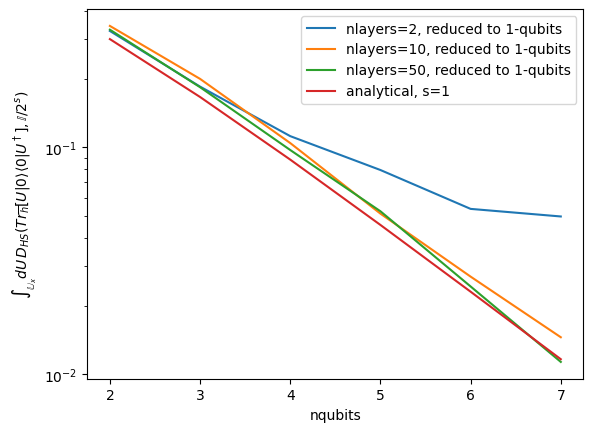

In [25]:
for i,nlayers in enumerate(nlayers_list):
    plt.semilogy(nqubits_list, int_hs_distance_each_nlayers_repeat[i], label=f'nlayers={nlayers}, reduced to {s}-qubits')

analytical_points = analytical(s, nqubits_list)
plt.semilogy(nqubits_list, analytical_points, label=f'analytical, s={s}')

plt.xlabel('nqubits')
#plt.ylabel('$D_{HS} ( \\rho_i^{(h)} , \mathbb{I}/2^s )$')
plt.ylabel('$\int_{\mathbb{U}_x}dU\,D_{HS}(Tr_{\overline{h}}[U|0\\rangle\langle0| U^\dagger],\mathbb{I}/2^s)$')
plt.legend()
plt.show()

### Gate parameters are chosen from iris dataset

In [26]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:,:4] # use first 4 features
Y = data[:,-1] # last column is the class

from sklearn.utils import shuffle
X, Y = shuffle(X, Y)

X_extended = []
for i in range(100):
    x_sample = [*X[i], *X[i], *X[i], *X[i]]
    X_extended.append(x_sample)

In [27]:
nsamples = 10**2
nqubits_list = np.arange(2, 8)
nlayers_list = [2,10,50]
s = 1
repeat_params = True

int_hs_distance_each_nlayers_iris = []
for nlayers in nlayers_list:
    int_hs_distance_each_nqubits = []
    for nqubits in nqubits_list:
        hsd = HSD(nqubits, nlayers, s, repeat_params)
        samples = []
        for _ in range(nsamples):
            samples.append(hsd.HSD_from_MMS(params))
        mean = np.mean(samples)
        int_hs_distance_each_nqubits.append(mean)
    int_hs_distance_each_nlayers_iris.append(int_hs_distance_each_nqubits)

In [28]:
l = int_hs_distance_each_nlayers_iris
path = "results/data/int_hs_distance_each_nlayers_iris.pkl"
with open(path, "wb") as f:
    pickle.dump(l, f)

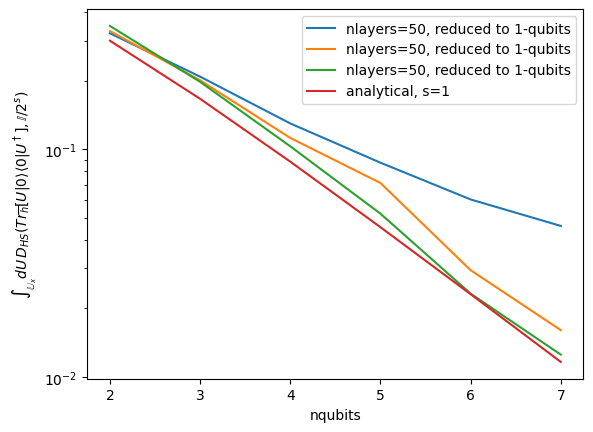

In [29]:
for i in range(len(nlayers_list)):
    plt.semilogy(nqubits_list, int_hs_distance_each_nlayers_iris[i], label=f'nlayers={nlayers}, reduced to {s}-qubits')

analytical_points = analytical(s, nqubits_list)
plt.semilogy(nqubits_list, analytical_points, label=f'analytical, s={s}')

plt.xlabel('nqubits')
plt.ylabel('$\int_{\mathbb{U}_x}dU\,D_{HS}(Tr_{\overline{h}}[U|0\\rangle\langle0| U^\dagger],\mathbb{I}/2^s)$')
plt.legend()
plt.show()